In [145]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [146]:
def f(x):
    return 3*x**2 - 4*x + 5

In [147]:
f(3.0)

20.0

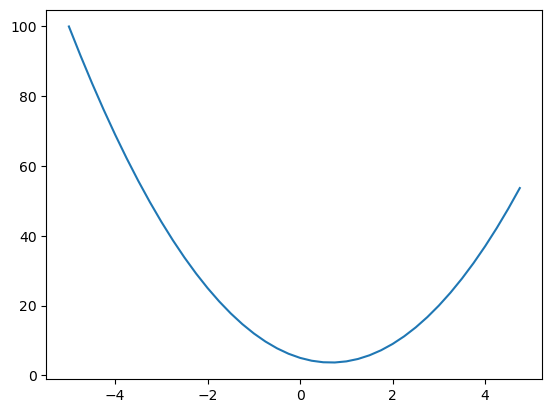

In [148]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [149]:
# Calculate derivative
h = 0.0001
x = -3.0

(f(x + h) - f(x))/h

-21.999700000066014

In [150]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [151]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2  = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [152]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return self * other**-1
        

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __repr__(self):
        return f"Value(data={self.data})"
    


In [153]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [154]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label='d'
e = d + c; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L'
L

Value(data=-8.0)

In [155]:
L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

In [156]:
#Visualize expression graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right || TB = Top to bottom
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [157]:
# Manually enter grad values.
L.grad = 1.0
e.grad = -2.0
f.grad = 4.0

d.grad = -2.0
c.grad = -2.0

a.grad = 6.0
b.grad = -4.0

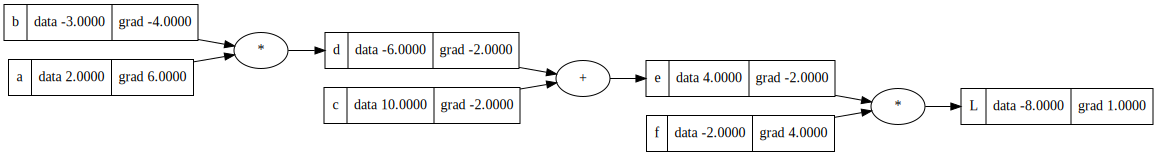

In [158]:
draw_dot(L)

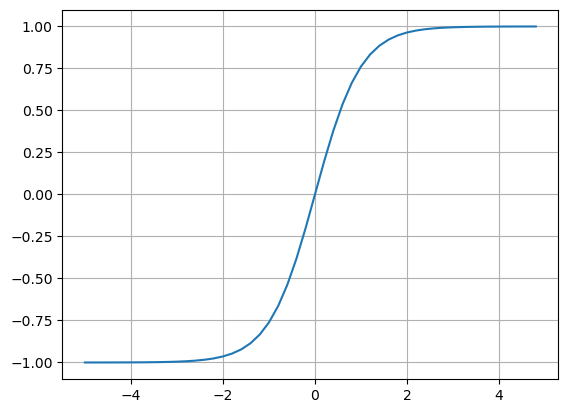

In [159]:
# Activation function - Tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Biological Neuron<br>
<img src="https://cs231n.github.io/assets/nn1/neuron.png" width="600"><br>
<br>
Mathematical Model<br>
<img src = "https://cs231n.github.io/assets/nn1/neuron_model.jpeg" width="600">

In [160]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# o = n.tanh(); o.label='o'
e = (2*n).exp()
o = (e-1) / (e+1)

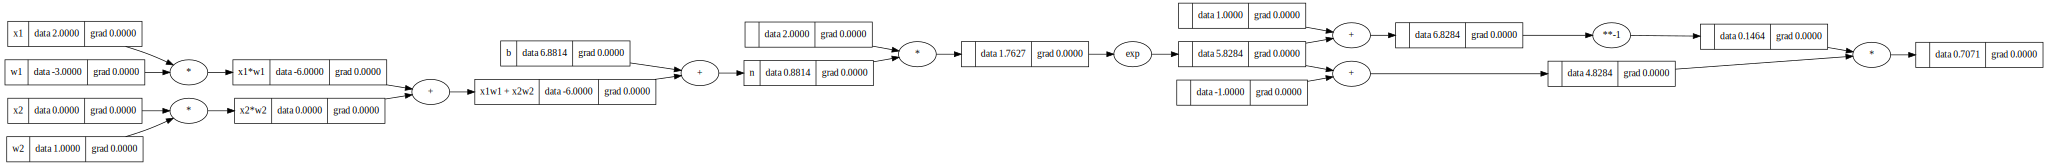

In [161]:
draw_dot(o)

In [162]:
# #Manual Backpropogation through neuron
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - o**2
# n.grad = 1 - o.data**2

# # Plus operation - local distributer of derivative
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # Mult derviative - y of x & z
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [163]:
# o.grad = 1.0
# o._backward()

# n._backward()
# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

In [164]:
# #Topological sort
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# o.grad = 1.0
# for node in reversed(topo):
#     node._backward()

In [165]:
# #Accumlative gradient
# a = Value(3.0, label='a')
# b = a + a; b.label='b'
# b.backward()
# draw_dot(b)

In [166]:
o.backward()

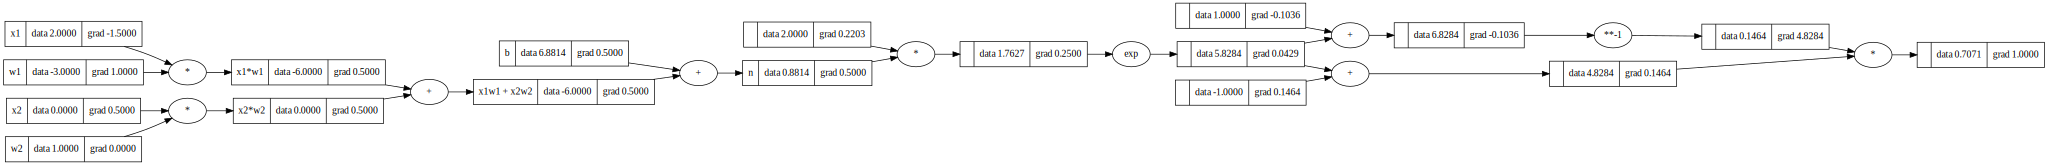

In [167]:
draw_dot(o)

In [168]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
          

In [169]:
x = [2.0, 3.0, -1.0]

# # Single neuron
# n = Neuron(2)
# n(x)

# # Layer of neurons
# n = Layer(2, 3)
# n(x)

# Multi-Layer Perceptron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6228547332037446)

In [170]:
len(n.parameters())

41

In [171]:
n.parameters()

[Value(data=0.5585253002835187),
 Value(data=-0.20820358179047393),
 Value(data=0.9968066348228322),
 Value(data=0.9847775275490573),
 Value(data=-0.8753273467926983),
 Value(data=0.53538537036339),
 Value(data=-0.3723210499583345),
 Value(data=0.6766331088642883),
 Value(data=0.27240550510916317),
 Value(data=0.6262360113126506),
 Value(data=0.8283747389245852),
 Value(data=-0.42418878699496365),
 Value(data=-0.4334149263969116),
 Value(data=-0.03951054000889043),
 Value(data=-0.0009830299688049493),
 Value(data=0.959349855207315),
 Value(data=-0.023065037876095484),
 Value(data=-0.22572826373288857),
 Value(data=-0.46433313122453246),
 Value(data=0.07304188408814327),
 Value(data=0.824809859062422),
 Value(data=-0.35345959077500955),
 Value(data=-0.9896285945344805),
 Value(data=0.7618286907610612),
 Value(data=0.37051982673424533),
 Value(data=-0.46350482719474817),
 Value(data=0.48620114475061227),
 Value(data=0.44295132252664393),
 Value(data=0.9422844201480709),
 Value(data=-0.23

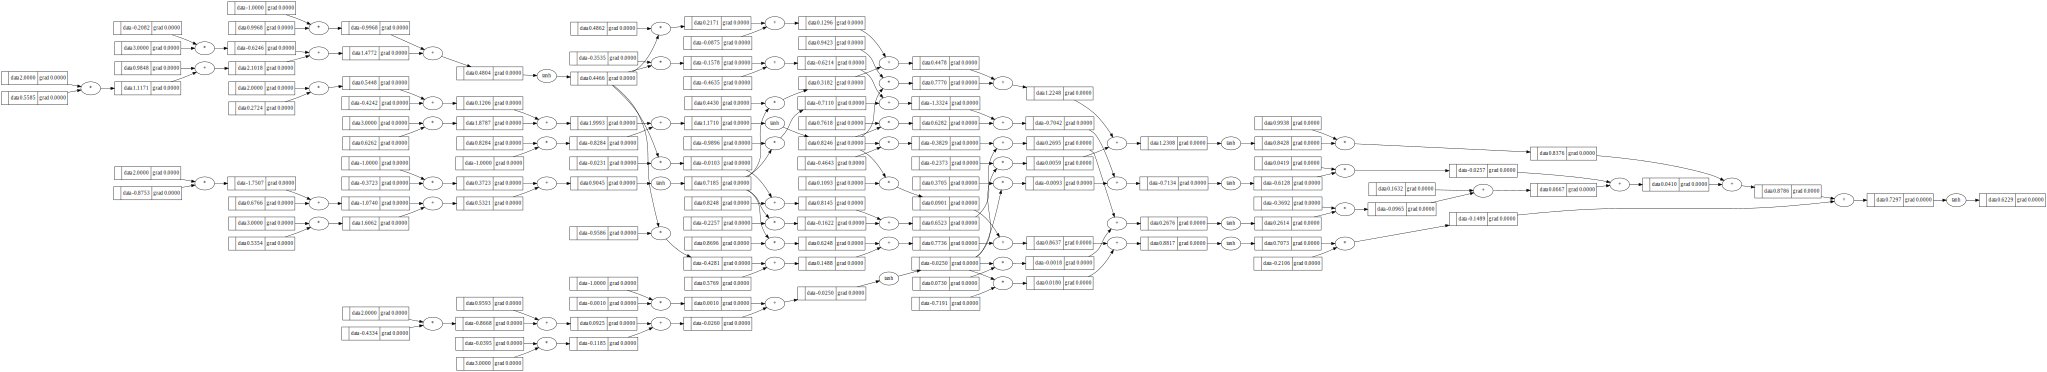

In [172]:
draw_dot(n(x))

In [173]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]

ys = [1.0, -1.0, -1.0, 1.0]

In [174]:
# ypred = [n(x) for x in xs]
# ypred

In [175]:
# #mean-squared error
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

In [176]:
# n.layers[0].neurons[0].w[0].grad
# n.layers[0].neurons[0].w[0].data

In [177]:
for k in range(100):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))   #mean-squared error

    #backward pass
    for p in n.parameters(): # zero_grad
        p.grad = 0.0
    loss.backward()

    # update - stocastic gradient descent
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 6.352517078597118
1 2.7186516174838644
2 1.6846577124521565
3 0.6028590461505132
4 0.21683359142891712
5 0.11779100336374246
6 0.08357103293582177
7 0.06471611622024727
8 0.052717638018851744
9 0.04441862828698819
10 0.038341488112584296
11 0.033701987006636694
12 0.03004554881285723
13 0.027090675467124854
14 0.024653816774472596
15 0.022610221378101394
16 0.02087216100875626
17 0.019376157648267524
18 0.018075153494746306
19 0.016933528646016622
20 0.015923827916625482
21 0.015024550127748712
22 0.014218618368526099
23 0.013492298576650746
24 0.012834420361314047
25 0.012235805946748269
26 0.011688845172981882
27 0.01118717477032127
28 0.01072543324386998
29 0.010299071366137736
30 0.009904204100939888
31 0.009537493765991825
32 0.009196057009218068
33 0.008877390123945485
34 0.008579308620525845
35 0.008299897978299699
36 0.008037473237491304
37 0.0077905456341525025
38 0.007557794886830067
39 0.007338046049056482
40 0.00713025007378939
41 0.006933467413638542
42 0.006746854117880

In [178]:
ypred

[Value(data=0.9841608682441613),
 Value(data=-0.9759209140272157),
 Value(data=-0.9740694481587703),
 Value(data=0.9670724249074146)]

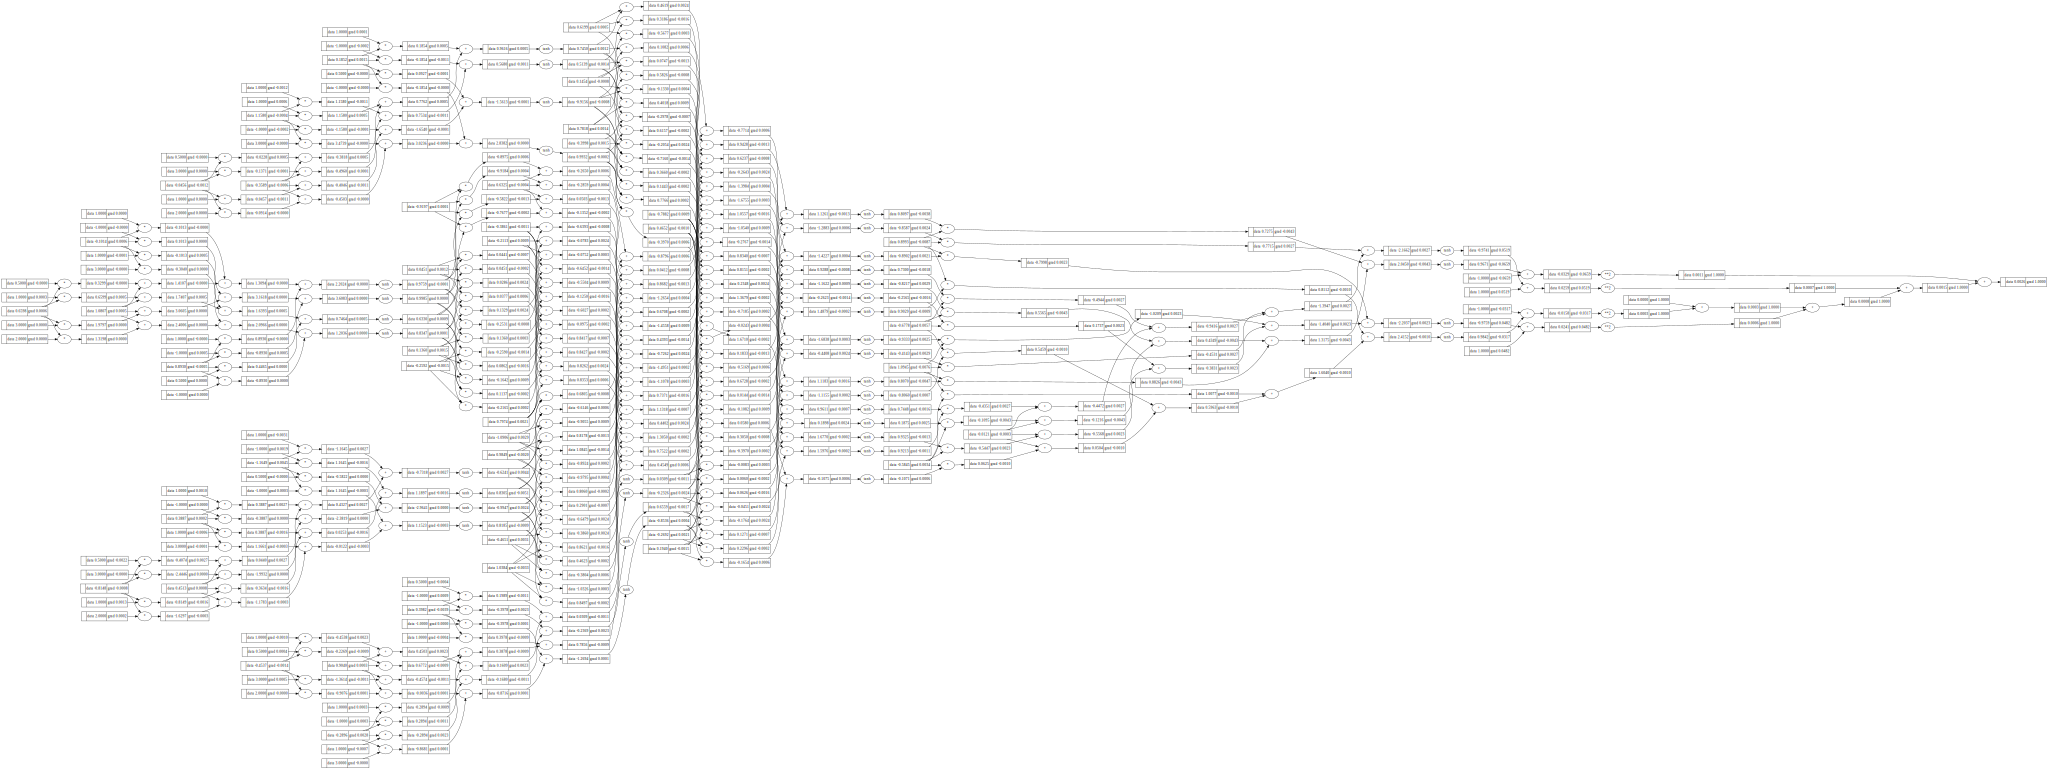

In [179]:
draw_dot(loss)